In [1]:
import random as r
import json

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib 

from architecture.rel_mse import rel_mse

# Set plotting parameters
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              #'font.family': 'serif',
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

# Boolean determining if figures should be saved (all figures or summary-only)
saveallfigs = False
savesumfigs = False

In [2]:
# Set data files and expt name

data_file_prefix = './data/KS_Eqn'
expt_name = "KS_Expt"
num_shifts = 50

In [3]:
def stack_predictions(data, num_shifts):
    len_pred = data.shape[1]-num_shifts
    prediction_list = []
    for j in range(num_shifts):
        prediction_list.append(data[:,j+1:j+1+len_pred,:])
    prediction_tensor = np.concatenate(prediction_list, axis=1)

    return prediction_tensor

In [4]:
def plot_predict_vs_true(i, pred_u, pred_f, u, f, ax1, ax2, title):
    
    # Grab the 'true' value
    true_u = u[i,:]
    true_F = f[i,:]

    # And predicted value
    predict_u = pred_u[i,:]
    predict_F = pred_f[i,:]

    # create a space vector
    x = np.linspace(0,2*np.pi, predict_u.shape[0])
    
    # Create the figure
    true_line = dict(color='cornflowerblue', lw=2)
    pred_line = dict(linestyle='--', color='k', alpha=0.8)

    ax1.plot(x, true_u, **true_line, label=r"True $u(x)$")
    ax1.plot(x, predict_u, **pred_line, label=r"Predicted u(x)")
    ax1.set_title("{}: U(x)".format(title))
    #ax1.set_xlabel("x")
    #ax1.set_ylabel("u(x)")
    #ax1.legend(loc='best')

    ax2.plot(x, true_F, **true_line, label=r"True $F(x)$")
    ax2.plot(x, predict_F, **pred_line, label=r"Predicted F(x)")
    ax2.set_title("{}: F(x)".format(title))

    #ax2.legend(loc='best')

    #plt.show()


In [5]:
def generate_compare_plot(full_model, u, f, title):
    fig, [ax1, ax2] = plt.subplots(2,3, sharex=True, figsize=(12,8))
    modes = ['Best', 'Mean', 'Worst']
    #for axes, mode in zip([(ax1, ax2), (ax3, ax4), (ax5, ax6)], ['Best', 'Mean', 'Worst']):

    for j in range(3):
        mode = modes[j]
        ax_u = ax1[j]
        ax_f = ax2[j]

        #mode = 'worst'
        i = find_sample(u, f, full_model, mode=mode)

        # Get a prediction
        _, _, F_pred, u_pred = full_model.predict((u,f))

        plot_predict_vs_true(i, u_pred, F_pred, u, f, ax_u, ax_f, "{} Case".format(mode))

    fig.suptitle(title, fontsize=16)
    ax1[0].set_ylabel("u(x)")
    ax2[0].set_ylabel("F(x)")
    for ax_f in ax2:
        ax_f.set_xlabel("x")
    #ax_u.legend(bbox_to_anchor=(1.25,0.5), loc='center')
    #ax_f.legend(bbox_to_anchor=(1.1,0.5), loc='center')
    true_line = ax_f.get_lines()[0]
    pred_line = ax_f.get_lines()[1]
    fig.legend((true_line, pred_line), ("True u(x) or f(x)", "Predicted u(x) or f(x)"), loc='upper right', bbox_to_anchor=(0.91,1.02))
    #plt.show()

In [6]:
def rel_mse(pred, true, den_nonzero=1e-5):
    num = np.mean(np.square(pred-true), axis=-1)
    den = np.mean(np.square(true), axis=-1)
    den += den_nonzero
    return np.divide(num, den) 
    
    
def find_sample(u,f, full_model, mode='worst', meanidx=None):
    _, _, pred_f, pred_u = full_model.predict(x=[u, f])

    f_scores = rel_mse(pred_f, f)
    u_scores = rel_mse(pred_u, u)
    
    score = np.abs(f_scores) + np.abs(u_scores)
    mean = np.mean(score)
    
    if mode.lower() == 'worst':
        idc = np.argmax(score)
    elif mode.lower() == 'best':
        idc = np.argmin(score)
    elif mode.lower() == 'mean':
        if meanidx:
            idcs = np.where(np.abs(score-mean) < 0.01*np.std(score))[0]
            idc = idcs[meanidx]
        else:
            idc = np.argmin((score-mean)**2)
        print(idc)
    else:
        print('{} mode not supported.'.format(mode))
        idc = np.argmin(score)
        
    return idc

def compute_losses(full_model, x, y):
    predicted_ys = full_model.predict(x=x)
    data = []
    for (pred_y, true_y) in zip(predicted_ys, y):
        data.append(rel_mse(pred_y, true_y, 1e-5))
    return data

In [7]:
def compute_rolling_average(x, window=6):
    if window % 2 != 0:
        raise ValueError("Window must be even.")
        return 1
    # Prepare a copy of the data
    x = x.copy().flatten()
    
    # Create an empty array for storing shifted copies of the data
    mean_array = np.ndarray((x.shape[0], int(window)))

    for i in range(int(window)):
        mean_array[:,i] = np.roll(x, i)

    half_window = int(window/2)
    roll_avg = np.mean(mean_array, axis=1)
    roll_avg = roll_avg[half_window:]
    
    return roll_avg

In [3]:
# Load the best model
save_prefix = 'results/{}/'.format(expt_name)
full_model = tf.keras.models.load_model(save_prefix + "final_model", 
                                     custom_objects={"rel_mse": rel_mse})

In [6]:
# Load the data
#data_train = np.load('{}_train1_x.npy'.format(data_file_prefix))
data_val = np.load('{}_val_x.npy'.format(data_file_prefix))

data_test1 = np.load('{}_test1_x.npy'.format(data_file_prefix))
data_test2 = np.load('{}_test2_x.npy'.format(data_file_prefix))
data_test3 = np.load('{}_test3_x.npy'.format(data_file_prefix))
data_test4 = np.load('{}_test4_x.npy'.format(data_file_prefix))
data_test5 = np.load('{}_test5_x.npy'.format(data_file_prefix))
data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])

In [10]:
# Score the different datasets
for dset, dtype in zip((data_val, data_test_all), ['Validation', 'Test']):
    dset_pred = stack_predictions(dset, num_shifts)
    losses = full_model.evaluate(x=dset, y=[dset, dset, dset_pred], batch_size=32, return_dict=True, verbose=0)
    print("LOSSES for {}:".format(dtype))
    print([loss for loss in losses])
    for loss in losses:
        print(losses[loss], end=", ")
    print("\n")

LOSSES for Validation:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss']
0.018701370805501938, 0.01195739395916462, 8.893346239347011e-05, 0.0066249486990273, 

LOSSES for Test:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss']
0.015054982155561447, 0.007570613641291857, 0.0001036909015965648, 0.007350593339651823, 



In [11]:
# Print out the optimizer learning rate:
print("\nLEARNING RATE:")
lr = full_model.optimizer.get_config()['learning_rate']
print(lr)


LEARNING RATE:
0.0002935886150225997


In [12]:
# Plot predictions
data = data_test_all

auto_output, outer_auto_output, predictions = full_model.predict(x=data)

In [14]:
print(auto_output.shape)
print(outer_auto_output.shape)
print(predictions.shape)

(5000, 51, 128)
(5000, 51, 128)
(5000, 50, 128)


In [15]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

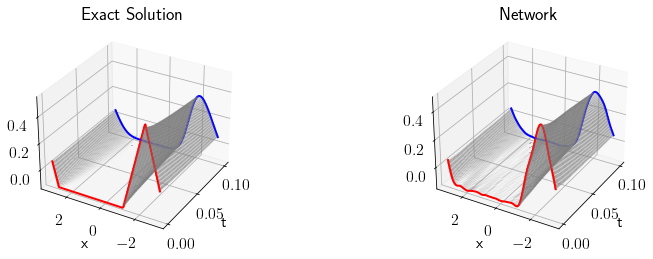

0.0027233567


In [38]:
# Exact solution (from data set)
ex_num = 4010
exact = data[ex_num,:,:]

network_pred = np.concatenate((auto_output[ex_num,0:1,:],predictions[ex_num,:,:]), axis=0)

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, 0.1, 51)
T, X = np.meshgrid(t_pts, x_pts)

fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=50,linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(network_pred),time_in=0,time_out=50,linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], network_pred[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], network_pred[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

plt.show()
#plt.savefig(filename,format='eps')  

pred = network_pred
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact),axis=-1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=-1)
rel_error = norm_2/denominator 
traj_error = np.mean(rel_error)
print(traj_error)

In [39]:
# Check autoencoder loss:
pred = auto_output
exact = data
denominator_nonzero = 10**(-5)
denominator = np.mean(np.square(exact), axis=-1)+denominator_nonzero
norm_2 = np.mean(np.square(exact-pred),axis=-1)
rel_error = norm_2/denominator 
auto_error = np.mean(rel_error)
print(auto_error)


0.0075706188


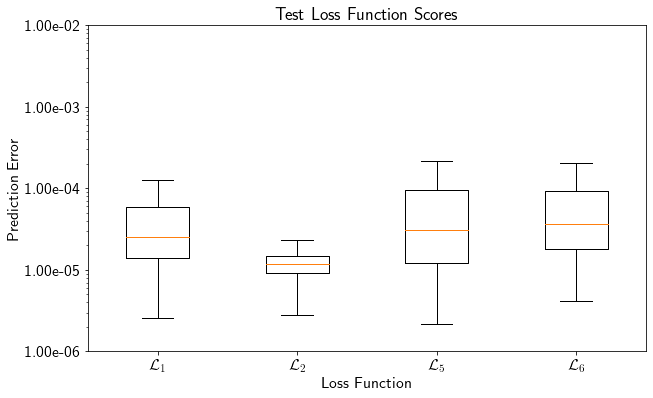

In [17]:
# Select a dataset to generate the plot from:
plot_for = 'Test'
dsets = {'Training': 0, 'Validation': 1, 'Test': 2, 'Polynomials': 3}
dset = datasets[dsets[plot_for]]

data = compute_losses(full_model, dset['x'], dset['y'])
labels = [r"$\mathcal{L}_1$", r"$\mathcal{L}_2$",  r"$\mathcal{L}_5$", r"$\mathcal{L}_6$"]


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title(r'{} Loss Function Scores'.format(plot_for))
ax.set_ylabel("Prediction Error")
ax.set_xlabel("Loss Function")
ax.boxplot(data, labels=labels, showfliers=False)
#ax.ticklabel_format(axis='y', style='sci')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.ylim([1e-6, 1e-2])

if saveallfigs or savesumfigs:
    plt.savefig(expt_name + "-{}-boxplot.svg".format(plot_for))
    
if savesumfigs:
    plt.savefig(expt_name + "-{}-boxplot.png".format(plot_for), transparent=True)

plt.show()

In [8]:
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

results_path = save_prefix + "final_model_history.json"
final_results = json.load(open(results_path))

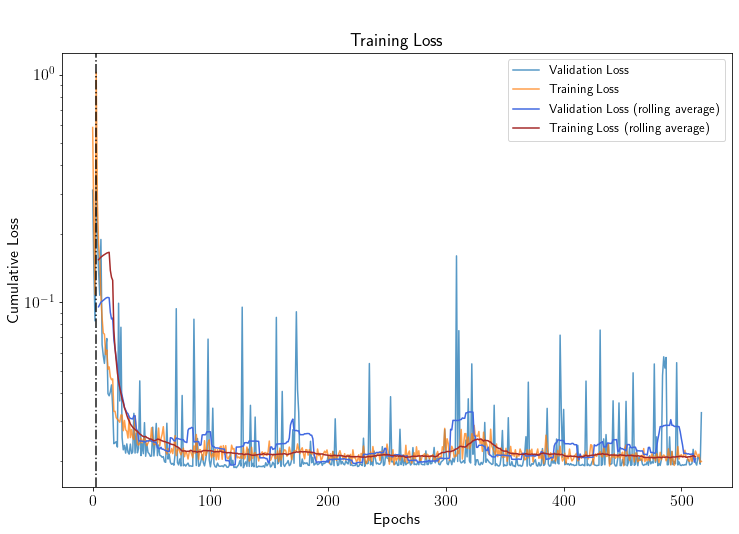

In [37]:
from matplotlib.patches import FancyArrowPatch

best_model_idc = np.argmin(init_results['best_loss'])

train_loss = init_results['aec_hist'][best_model_idc]['loss'] + init_results['full_hist'][best_model_idc]['loss'] + final_results['loss']
val_loss = init_results['aec_hist'][best_model_idc]['val_loss'] + init_results['full_hist'][best_model_idc]['val_loss'] + final_results['val_loss']

train_loss = np.asarray(train_loss)
val_loss = np.asarray(val_loss)

roll_window = 20
train_roll = compute_rolling_average(train_loss, window=roll_window)
val_roll = compute_rolling_average(val_loss, window=roll_window)
roll_idcs = np.arange(train_loss.shape[0])[int(roll_window/4):-int(roll_window/4)]

plt.figure()

plt.semilogy(val_loss, label="Validation Loss", alpha=0.75)
plt.semilogy(train_loss, label="Training Loss", alpha=0.75)

plt.semilogy(roll_idcs, val_roll, color='royalblue', label="Validation Loss (rolling average)")
plt.semilogy(roll_idcs, train_roll, color='brown', label="Training Loss (rolling average)")

plt.axvline(3, linestyle='-.', color='k', alpha=0.9)
#plt.axvline(325)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Cumulative Loss")
plt.legend(loc='upper right')
ax = plt.gca()
arrow = FancyArrowPatch((350,2), (80,2), fc='k', arrowstyle='Simple', mutation_scale=15)
ax.add_patch(arrow)
ax.annotate(r"Operator $L$ enabled", xy=(360,1.8), fontsize=14)

if saveallfigs:
    plt.savefig("{}-trainingloss.png".format(expt_name), transparent=True)

plt.show()

In [11]:
[key for key in final_results]

['loss',
 'output_1_loss',
 'output_2_loss',
 'output_3_loss',
 'val_loss',
 'val_output_1_loss',
 'val_output_2_loss',
 'val_output_3_loss',
 'random_seed']

In [21]:
np.min(final_results['loss'])

0.014084399677813053

In [20]:
final_results['loss'][261]

0.023558910936117172